In [30]:
import torch
from torch import nn
from torch.nn import functional as F
from torchvision import transforms
from torch.utils.data import DataLoader,Dataset
from torch import optim
import os
import csv
from PIL import Image
import warnings
warnings.simplefilter('ignore')
from torchvision import datasets

#载入数据
trans = transforms.Compose((transforms.Resize((32,32)),transforms.ToTensor()))
train_set = datasets.MNIST('./num',train=True,transform=trans, download=False)
#mnist中的test_set一共有1万张照片，这里我们把前5000张用作validation_set,后5000张用作test_set
val_set = list(datasets.MNIST('./num',train=False,transform=trans, download=False))[:5000]
test_set = list(datasets.MNIST('./num',train=False,transform=trans, download=False))[5000:]

train_loader = DataLoader(train_set,batch_size=150,shuffle=True)
val_loader = DataLoader(val_set,batch_size=50,shuffle=True)
test_loader = DataLoader(test_set,batch_size=50,shuffle=True)


#构建resblock
class resblock(nn.Module):
    def __init__(self,ch_in,ch_out,stride=1):
        super(resblock,self).__init__()
        self.conv_1 = nn.Conv2d(ch_in,ch_out,kernel_size=3,stride=stride,padding=1)
        self.bn_1 = nn.BatchNorm2d(ch_out)
        self.conv_2 = nn.Conv2d(ch_out,ch_out,kernel_size=3,stride=1,padding=1)
        self.bn_2 = nn.BatchNorm2d(ch_out)
        self.ch_trans = nn.Sequential()
        if ch_in != ch_out:
            self.ch_trans = nn.Sequential(nn.Conv2d(ch_in,ch_out,kernel_size=1,stride=stride),nn.BatchNorm2d(ch_out))
        #ch_trans表示通道数转变。因为要做short_cut,所以x_pro和x_ch的size应该完全一致
        
    def  forward(self,x):
        x_pro = F.relu(self.bn_1(self.conv_1(x)))
        x_pro = self.bn_2(self.conv_2(x_pro))
        
        #short_cut:
        x_ch = self.ch_trans(x)
        out = x_pro + x_ch
        out = F.relu(out)
        return out 
    
    
#搭建resnet
class Resnet18(nn.Module):
    def __init__(self,num_class):
        super(Resnet18,self).__init__()
        self.conv_1 = nn.Sequential(
        nn.Conv2d(1,16,kernel_size=3,stride=3,padding=0),
        nn.BatchNorm2d(16))
        self.block1 = resblock(16,32,1) 
        self.block2 = resblock(32,64,1) 
        self.block3 = resblock(64,128,2)
        self.block4 = resblock(128,256,2)
        self.outlayer = nn.Linear(256*3*3,num_class)#这个256*3*3是根据forward中x经过4个resblock之后来决定的
        
    def forward(self,x):
        x = F.relu(self.conv_1(x))
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = x.reshape(x.size(0),-1) #进行打平操作
        result = self.outlayer(x)
        return result       

In [31]:
print(train_set)

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./num
    Split: Train
    StandardTransform
Transform: Compose(
               Resize(size=(32, 32), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
           )


In [32]:
list(datasets.MNIST('./num',train=False,transform=trans, download=False))

[(tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]]),
  7),
 (tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]]),
  2),
 (tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]]),
  1),
 (tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
      

In [33]:
print('GPU:', torch.cuda.is_available())

GPU: True


In [34]:
device = torch.device('cuda')
model = Resnet18(10).to(device) #模型初始化，10代表一共有10种类别
print('total parameters of trianing model: {}'.format(sum(map(lambda p:p.numel(),model.parameters()))))
loss_fn = nn.CrossEntropyLoss() #选择loss_function
optimizer = optim.Adam(model.parameters(),lr=1e-3) #选择优化方式

total parameters of trianing model: 1246122


In [35]:
len(train_set)

60000

In [58]:
train_set = list(datasets.MNIST('./num',train=True,transform=trans, download=False))[:50000]
train_loader = DataLoader(train_set,batch_size=100,shuffle=True)

In [59]:
len(train_set)

50000

In [60]:
60000/150

400.0

In [61]:
len(train_loader)

334

In [62]:
# evaluate用于检测模型的预测效果，validation_set和test_set是同样的evaluate方法
def evaluate(model,loader):
    correct_num = 0
    total_num = len(loader.dataset)
    for img,label in loader: #lodaer中包含了很多batch，每个batch有32张图片
        img,label = img.to(device),label.to(device)
        with torch.no_grad():
            logits = model(img)
            pre_label = logits.argmax(dim=1)
        correct_num += torch.eq(pre_label,label).sum().float().item()
    
    return correct_num/total_num 

import time
time_start=time.time()

best_epoch,best_acc = 0,0
for epoch in range(10): #时间关系，我们只训练10个epoch
    for batch_num,(img,label) in enumerate(train_loader):
        #img.size [b,3,224,224]  label.size [b]
        img,label = img.to(device),label.to(device)
        logits = model(img)
        loss = loss_fn(logits,label)
        if (batch_num+1)%100 == 0:
            print('epoch:{} batch:{} loose:{}'.format(epoch+1,batch_num+1,loss.item()))
         
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    if epoch%2==0: #这里设置的是每训练两次epoch就进行一次validation
        val_acc = evaluate(model,val_loader)
        #如果val_acc比之前的好，那么就把该epoch保存下来，并把此时模型的参数保存到指定txt文件里
        if val_acc>best_acc:
           
            print('The accuracy on the validation datset: {}'.format(val_acc))
            best_epoch = epoch
            best_acc = val_acc
            torch.save(model.state_dict(),'mnist_resnet_ckp.txt')
            
time_end=time.time()    
print('totally cost',time_end-time_start)    

print('best_acc:{},best_epoch:{}'.format(best_acc,best_epoch))
model.load_state_dict(torch.load('mnist_resnet_ckp.txt'))
print('training finished, now start testing test_set')

test_acc = evaluate(model,test_loader)
print('The accuracy on the test set: {}'.format(test_acc))

epoch:1 batch:100 loose:0.01190563477575779
epoch:1 batch:200 loose:0.007561173290014267
epoch:1 batch:300 loose:0.004583355505019426
The accuracy on the validation datset: 0.9848
epoch:2 batch:100 loose:0.0009128344245254993
epoch:2 batch:200 loose:0.03317719325423241
epoch:2 batch:300 loose:0.0001585501158842817
epoch:3 batch:100 loose:7.578304939670488e-05
epoch:3 batch:200 loose:0.004537788685411215
epoch:3 batch:300 loose:0.000204327967367135
The accuracy on the validation datset: 0.9874
epoch:4 batch:100 loose:0.0015941925812512636
epoch:4 batch:200 loose:0.002064422471448779
epoch:4 batch:300 loose:0.0011864980915561318
epoch:5 batch:100 loose:0.0006757077644579113
epoch:5 batch:200 loose:0.001219549565576017
epoch:5 batch:300 loose:0.0022280323319137096
The accuracy on the validation datset: 0.9878
epoch:6 batch:100 loose:0.003509538946673274
epoch:6 batch:200 loose:0.00027682469226419926
epoch:6 batch:300 loose:0.005328829865902662
epoch:7 batch:100 loose:0.0007766792550683022

[[0.00136738]] [2.57748957]


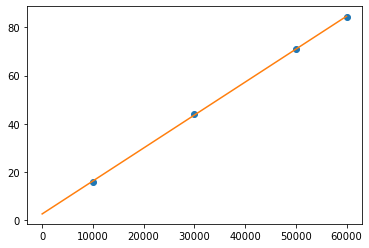

In [65]:
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
#4019 42.43043494224548 40199  40199  281.12068939208984 120600 820.6956114768982  201001 1340  361803 2563.249900817871
x = [[10000],[30000],[50000],[60000] ]
y = [[16],[44],[71],[84.41726922988892]]
reg = LinearRegression().fit(x,y)
x_pre = np.linspace(0,60000,5)
x_pre = x_pre.reshape(-1,1)
y_pre = reg.predict(x_pre)
plt.plot(x, y,'o')
plt.plot(x_pre, y_pre)
a = reg.coef_
b = reg.intercept_
print(a,b)
plt.show()

[[0.00231278]] [-15.11025307]


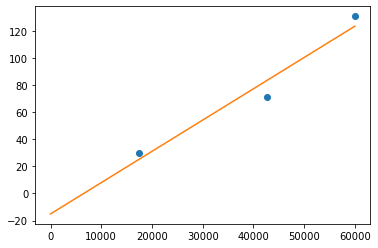

In [69]:
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
#4019 42.43043494224548 40199  40199  281.12068939208984 120600 820.6956114768982  201001 1340  361803 2563.249900817871
x = [[17400],[42600],[60000] ]
y = [[30.202638864517212],[71],[131]]
reg = LinearRegression().fit(x,y)
x_pre = np.linspace(0,60000,5)
x_pre = x_pre.reshape(-1,1)
y_pre = reg.predict(x_pre)
plt.plot(x, y,'o')
plt.plot(x_pre, y_pre)
a = reg.coef_
b = reg.intercept_
print(a,b)
plt.show()

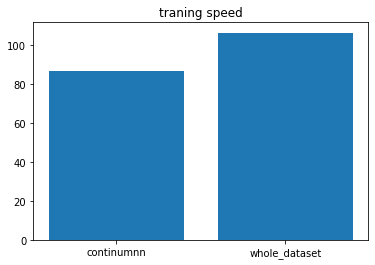

In [67]:
training_time = [(30+71), 106.477]
training_type = ['continumnn', 'whole_dataset']
plt.bar(training_type, training_time)
plt.title('traning speed')
plt.show()

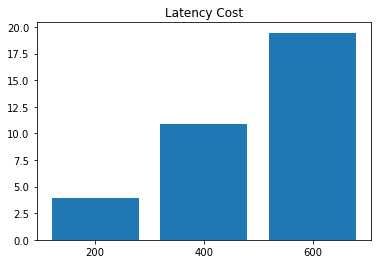

In [68]:
Latency_Cost = [3.895635198, 10.858555937999999, 19.466332678]
data_size = ['200','400', '600']
plt.bar(data_size, Latency_Cost)
plt.title('Latency Cost')
plt.show()